# imports and loading

In [1]:
# %pip install --upgrade ultralytics

In [2]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 14928MiB)
Setup complete ✅ (4 CPUs, 14.6 GB RAM, 35.9/98.2 GB disk)


In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchvision.models import resnet34
from torch import nn
from pytorch_lightning import Trainer
from torchvision.transforms.functional import pad
from torch.utils.data import random_split
import ast
import shutil
import random

In [16]:
import sys
repo_dir = '/home/jupyter/mga'
repo_url = 'https://github.com/roihezkiyahu/mga.git'

if os.path.exists(repo_dir):
    %cd $repo_dir
    !git pull
    %cd 
else:
    print("cloning")
    !git clone $repo_url

sys.path.append(repo_dir)

from mga.utils.util_funcs import create_dataframe, create_bounding_boxes, sort_yolo_folders, load_bounding_boxes, annotation_to_labels
from mga.plot_functions.mga_plt import plot_w_box_from_path
from mga.data.global_data import outlier_images

/home/jupyter/mga
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.
/home/jupyter


### pathing

In [14]:
tr_img = 'train/images'
tr_an  = 'train/annotations'
tr_labels  = 'labels'
generated_path = "gen_line/gen_line"
train_df_path = "train_df.csv"

base_dir = 'dataset_line'
images_path = os.path.join(base_dir, "train", 'images')

### order the data

In [6]:
train_df = pd.read_csv(train_df_path)
valid_names = list(train_df[train_df["chart-type"] == "line"]["name"])

In [7]:
sort_yolo_folders(tr_img, tr_labels, valid_names=valid_names, base_dir=base_dir)

100%|██████████| 3030/3030 [00:30<00:00, 97.96it/s] 


In [10]:
images_list = os.listdir(images_path)

# Copy from gen path to yolo datasets folder

In [36]:
image_paths = [os.path.join(generated_path, image) for image in os.listdir(generated_path) if image.endswith(".jpg")]
chart_boxes = [os.path.join(generated_path, label) for label in os.listdir(generated_path) if label.endswith(".txt")]
annotations = [os.path.join(generated_path, annotation) for annotation in os.listdir(generated_path) if annotation.endswith(".json")]
if chart_boxes:
    image_paths = [f"{name.split('.')[0]}.jpg" for name in chart_boxes]
    for img_path, chart_box in tqdm(zip(sorted(image_paths), sorted(chart_boxes))):
        annotation_to_labels(img_path, chart_box, is_box=True, labels_folder= os.path.join(base_dir, "train", "labels"),
                             img_folder = os.path.join(base_dir, "train", 'images'))
else:
    for img_path, chart_box in tqdm(zip(sorted(image_paths), sorted(annotations))):
        annotation_to_labels(img_path, chart_box, is_box=False, labels_folder = os.path.join(base_dir, "labels"),
                             img_folder = os.path.join(base_dir, 'images'))

9130it [03:14, 46.86it/s]


### image plotting (validating bboxes)

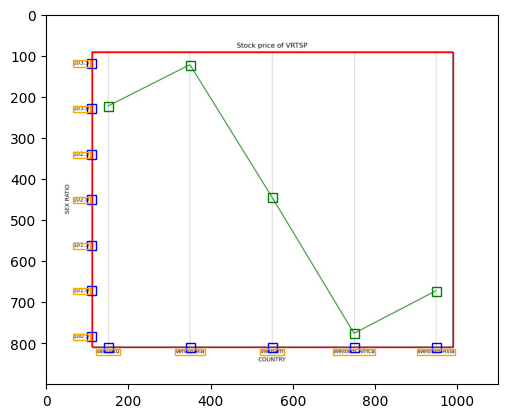

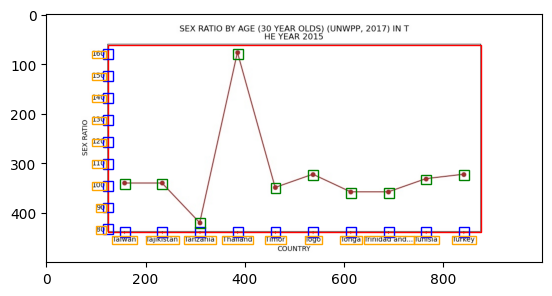

In [37]:
box_classes = ["plot", "x_tick", "y_tick", "scatter_point", "bar", "dot_point", "line_point", "tick_label"]
colors_list = ["r", "blue", "blue", "black", "purple", "yellow", "green", "orange"]

for i in range(2):
    plot_w_box_from_path(i, base_path = os.path.join(base_dir,'train'))


# YOLO

In [38]:
# Let's create the content for the `dataset.yaml` file

content = """
train: /home/jupyter/dataset_line/train/images
val: /home/jupyter/dataset_line/valid/images
test: /home/jupyter/dataset_line/test/images

nc: 8
names: ["plot", "x_tick", "y_tick", "scatter_point", "bar", "dot_point", "line_point", "tick_label"]
"""

# Now, we'll save the content to a `dataset.yaml` file
file_path = "dataset.yaml"

with open(file_path, 'w') as file:
    file.write(content)

file_path

'dataset.yaml'

In [39]:
model = YOLO('yolov8s.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [40]:
acc_device = "cuda" if torch.cuda.is_available() else "cpu"
batch = 32
epochs = 100
optimizer = 'Adam'
lr0 = 1e-4
label_smoothing = 0
cache = False
imgsz = 640
augmentations = {
    "hsv_h": 0.2,
    "hsv_s": 0.5,
    "hsv_v": 0.5,
    "translate": 0.15,
    "scale": 0.3,
    "fliplr": 0.5,
    "mosaic": 0,
    "close_mosaic": 0

}

project = "/home/jupyter/line_yolo"
name = "/home/jupyter/line_yolo/batch_32_aug10k"
last_weight = os.path.join(name, 'weights/last.pt')

if os.path.exists(last_weight):
    model = YOLO(last_weight)

res = model.train(data="dataset.yaml", epochs=epochs, imgsz = imgsz, resume=True,
            batch=batch, cache=cache, device=acc_device, lr0=lr0, optimizer=optimizer, label_smoothing=label_smoothing,
                 project = project, name = name, **augmentations)

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 14928MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=dataset.yaml, epochs=100, patience=50, batch=8, imgsz=480, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=line_yolo, name=aug10k, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fa

RuntimeError: Dataset 'dataset.yaml' error ❌ 
Dataset 'dataset.yaml' images not found ⚠️, missing path '/home/jupyter/datasets/dataset_line/valid/images'
Note dataset download directory is '/home/jupyter/datasets'. You can update this in '/home/jupyter/.config/Ultralytics/settings.yaml'

In [ ]:
def get_random_image(dir_path):
    images = [os.path.join(dir_path, "images", f) for f in os.listdir(os.path.join(dir_path, "images")) if f.endswith('.jpg')]
    return random.choice(images)

train_img_name = get_random_image(os.path.join(base_dir, 'train'))
valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
test_img_name = get_random_image(os.path.join(base_dir, 'test'))

In [ ]:
train_img_name = get_random_image(os.path.join(base_dir, 'train'))
valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
test_img_name = get_random_image(os.path.join(base_dir, 'test'))
results = model(source=test_img_name, augment=False)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

In [ ]:
for i in range(150):
    train_img_name = get_random_image(os.path.join(base_dir, 'train'))
    valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
    test_img_name = get_random_image(os.path.join(base_dir, 'test'))
    train_img_name = get_random_image(os.path.join(base_dir, 'train'))
    valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
    test_img_name = get_random_image(os.path.join(base_dir, 'test'))
    results = model(source=train_img_name, augment=False)
    res_plotted = results[0].plot(font_size =0.5, labels=False)
    plt.imshow(res_plotted)
    plt.show()
    
    results = model(source=valid_img_name, augment=False)
    res_plotted = results[0].plot(font_size =0.5, labels=False)
    plt.imshow(res_plotted)
    plt.show()
    
    results = model(source=test_img_name, augment=False)
    res_plotted = results[0].plot(font_size =0.5, labels=False)
    plt.imshow(res_plotted)
    plt.show()

In [ ]:
# !yolo task=detect mode=train model=yolov8s.yaml data=dataset.yaml

In [ ]:
stop